<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/Autoencoders_Variational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQk4anYFFsY3OTqb6RP4oTBhqPM0P1u80tSRA&usqp=CAU" width=75 height=50>

*Algirdas Laukaitis*

<br><br>

---



# PART 1

<font color='SeaGreen'>Download and prepare the CIFAR10 dataset</font>        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/PICOL_Download.svg/1024px-PICOL_Download.svg.png" width=100 height=100>


In [3]:
#@title The code that loads the CIFAR-10 dataset, a database featuring images of various objects from our world.
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [4]:
#@title Normalizing the pixel values is crucial, ensuring our data is ready for the challenges ahead

train_images, test_images = train_images / 255.0, test_images / 255.0

<br><br>

---
###<font color='SeaGreen'>Let's plot the first 100 images </font>


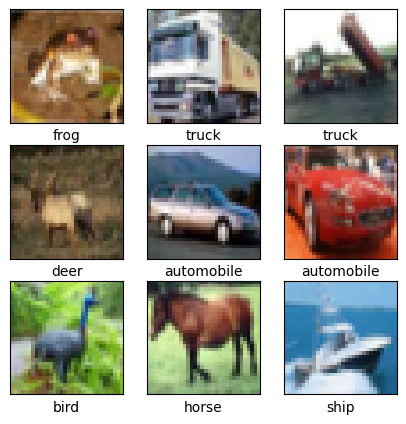

In [5]:
#@title  Let's navigate through a hundred images from CIFAR-10 to ensure our data is intact. It's essential to know what we're up against.
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


<br><br><br><br>


# <font color='SeaGreen'>Variational autoencoder</font>        <img src="https://upload.wikimedia.org/wikipedia/commons/4/4a/VAE_Basic.png" width=400 height=250>




https://keras.io/examples/generative/vae/

<br><br>

---
###<font color='SeaGreen'>Step 2. Model </font>

In [6]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers




In [7]:
@keras.saving.register_keras_serializable(package="my_package")
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon



    def get_config(self):
        config = super().get_config()
        config.update(
            {
            "seed_generator": keras.saving.serialize_keras_object(self.seed_generator),
            }
        )

        return config


    @classmethod
    def from_config(cls, config):
        config["seed_generator"] = keras.saving.deserialize_keras_object(config["seed_generator"])

        return cls(**config)



In [8]:
latent_dim = 16

# encoder_inputs = keras.Input(shape=(32, 32, 3))
# x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
# x = layers.Conv2D(96, 3, strides=2, activation="relu", padding="same")(x)
# x = layers.Flatten()(x)
# x = layers.Dense(32, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
# encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
# encoder.summary()

encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [10]:
# latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(32, activation="relu")(latent_inputs)
# x = layers.Dense(96 * 8 * 8, activation="relu")(x)  # Reverse of Flatten
# x = layers.Reshape((8, 8, 96))(x)
# x = layers.Conv2DTranspose(96, 3, strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)  # Output shape matches input
# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(8 * 8 * 128, activation="relu")(x)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

encoder.summary()
decoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 128)      │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 128)      │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      1,048,704 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 16)             │          2,064 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 16)             │          2,064 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 16)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,146,976 (4.38 MB)

 Trainable params: 1,146,528 (4.37 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,300,419 (4.96 MB)

 Trainable params: 1,300,035 (4.96 MB)

 Non-trainable params: 384 (1.50 KB)

In [11]:
keras.saving.get_custom_objects().clear()

@keras.saving.register_keras_serializable(package="my_package")  # https://keras.io/guides/serialization_and_saving/
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    # Define the call method for inference
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed


    def get_config(self):
        config = super().get_config()
        config.update(
            {
            "encoder": keras.saving.serialize_keras_object(self.encoder),
            "decoder": keras.saving.serialize_keras_object(self.decoder),
            "total_loss_tracker": keras.saving.serialize_keras_object(self.total_loss_tracker),
            "reconstruction_loss_tracker": keras.saving.serialize_keras_object(self.reconstruction_loss_tracker),
            "kl_loss_tracker": keras.saving.serialize_keras_object(self.kl_loss_tracker),
            }
        )

        return config



    @classmethod
    def from_config(cls, config):
        #config["encoder"] = keras.layers.deserialize(config["encoder"])
        #config["decoder"] = keras.layers.deserialize(config["decoder"])

        config["encoder"] = keras.saving.deserialize_keras_object(config["encoder"])
        config["decoder"] = keras.saving.deserialize_keras_object(config["decoder"])
        config["total_loss_tracker"] = keras.saving.deserialize_keras_object(config["total_loss_tracker"])
        config["reconstruction_loss_tracker"] = keras.saving.deserialize_keras_object(config["reconstruction_loss_tracker"])
        config["kl_loss_tracker"] = keras.saving.deserialize_keras_object(config["kl_loss_tracker"])


        return cls(**config)

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())


In [10]:
# if os.path.exists("Variational AutoEncoder_cifar10_500Kp.weights.h5"):
#     print("The model exists.")
#     vae.load_weights("Variational AutoEncoder_cifar10_500Kp.weights.h5")


In [11]:
#train_images = train_images[:100]

In [13]:
vae.fit(train_images, epochs=50, batch_size=128, verbose=1)
# vae.fit(train_images, epochs=100, batch_size=128, verbose=0)
# vae.fit(train_images, epochs=1, batch_size=128, verbose=1)

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - kl_loss: 5.3747 - loss: 672.8731 - reconstruction_loss: 667.4987
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - kl_loss: 11.6227 - loss: 637.0079 - reconstruction_loss: 625.3853
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 13.0892 - loss: 631.7312 - reconstruction_loss: 618.6422
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - kl_loss: 13.8252 - loss: 629.8862 - reconstruction_loss: 616.0610
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - kl_loss: 14.0429 - loss: 628.5579 - reconstruction_loss: 614.5150
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - kl_loss: 14.2832 - loss: 628.9573 - reconstruction_loss: 614.6741
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - kl_loss: 14.5855 - loss: 628.1674 - reconstruction_loss: 613.5820
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - kl_loss: 14.8246 - loss: 627.6331 - reconstruction_loss: 612.8083
Epoch 9/100
391/391

In [14]:
vae.save_weights("Variational AutoEncoder_cifar10_500Kp.weights.h5")

In [15]:
n = 10
decoded_train_imgs = vae.predict(train_images[:n])
decoded_test_imgs = vae.predict(test_images[:n])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


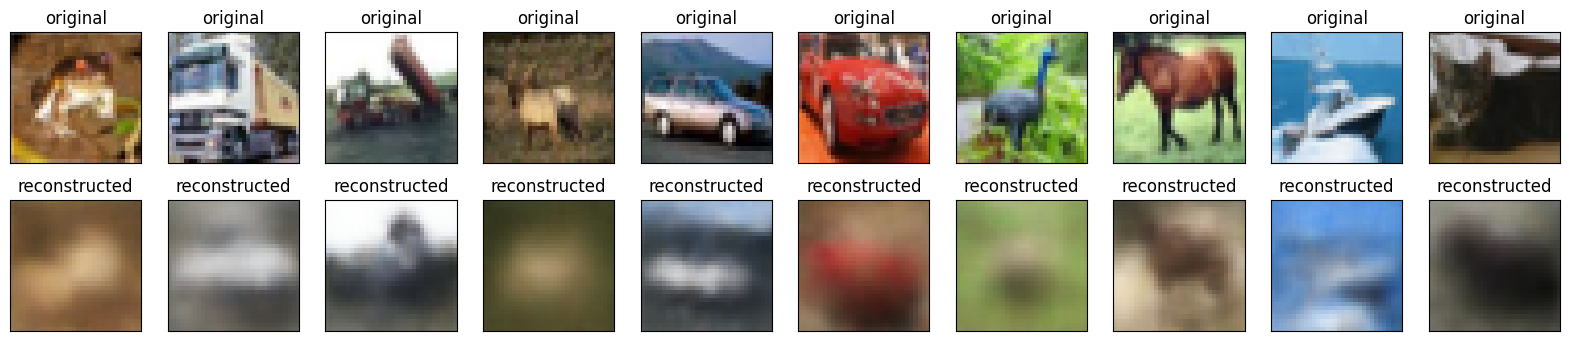

In [16]:

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(train_images[i]) # test_images[i]  train_images[i]
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_train_imgs[i]) # decoded_train_imgs  decoded_test_imgs[i]
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

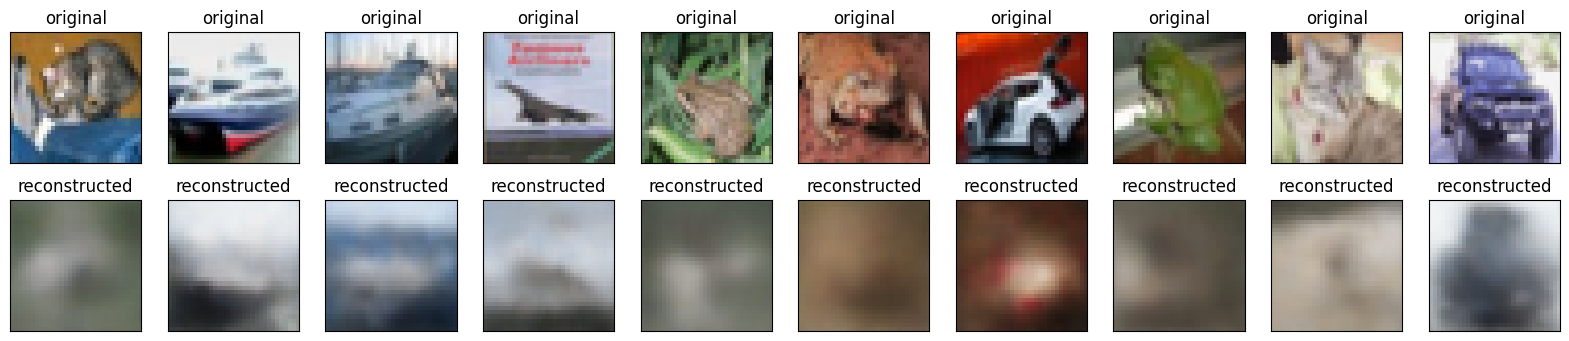

In [17]:

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_images[i]) # test_images[i]  train_images[i]
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_test_imgs[i]) # decoded_train_imgs  decoded_test_imgs[i]
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
'''
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi,1,1]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,

            ] = digit[:,:,1]

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

'''

<br><br>

---
###<font color='SeaGreen'>Step 3. Train and evaluate the model</font>

In [ ]:
'''
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()




plot_label_clusters(vae,   train_images, train_labels )

'''